<a href="https://colab.research.google.com/github/pravda27/hacks_ai/blob/main/sherem_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузим нужные библиотеки и данные

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from numpy import median
import matplotlib.dates as mdates
import datetime as dt
import plotly.express as px 
from plotly import graph_objects as go
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.metrics import recall_score, precision_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn import tree
import numpy as np
from sklearn.metrics import f1_score
from google.colab.data_table import DataTable
DataTable.max_columns = 80
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/hacks_ai/sherem

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/hacks_ai/sherem


Данные

In [3]:
rev = pd.read_excel("05.2022_Выручка1.xlsx")
pas = pd.read_excel("05.2022_Пассажиропоток.xlsx")
sced = pd.read_excel("Расписание рейсов 05-06.2022.xlsx")
airport = pd.read_excel("Справочник_AIRPORTS.xlsx")
airline = pd.read_excel("Справочник_AIRLINES.xlsx")

## Рассмотрим датасет поближе

In [4]:
print(rev.shape)
print(pas.shape)
print(sced.shape)
print(airport.shape)
print(airline.shape)

(11840, 8)
(53482, 7)
(16120, 12)
(1583, 5)
(1643, 3)


In [5]:
rev.head(3)

,TimeThirty,DAT,Торговая точка,Касса,orgtype,terminal,tzone,TotalSumm
0,2022-05-01 00:00:00.000,2022-05-01,Торговая точка 0601,7683,Общепит,B,Чистая зона ВВЛ-вылет,755448.0
1,2022-05-04 13:30:00.000,2022-05-04,Торговая точка 2373,3114,Общепит,B,Общедоступная зона-вылет,46800.0
2,2022-05-05 18:00:00.000,2022-05-05,Торговая точка 8998,9887,Торговля,B,Чистая зона ВВЛ-вылет,160160.0


In [6]:
pas.head(3)

,Дата рейса,Рейс,Вход в чистую зону,Выход на рейс,Терминал,Авиакомпания,Направление куда летит
0,2022-05-01,5N 237,2022-04-30 21:46:20,2022-05-01 00:21:00,B,5N,OVB
1,2022-05-01,5N 237,2022-04-30 21:46:47,2022-05-01 00:21:00,B,5N,OVB
2,2022-05-01,5N 237,2022-04-30 21:47:47,2022-05-01 00:21:00,B,5N,OVB


In [7]:
sced = sced.drop(columns =['INB','OUT'], axis = 1)
sced.head(3)

,FLIGHT_DATE,AIRCRAFTTYPE,AIRLINE,REG,INB_FLIGHT,INB_BEST_TIME,INB_ROU,OUT_FLIGHT,OUT_BEST_TIME,OUT_ROU
0,2022-05-01,32N,SU,73732,SU 1463,2022-05-01 15:41:00,OVB,SU 1462,2022-05-02 06:21:00,OVB
1,2022-05-01,32A,SU,73179,SU 1249,2022-05-01 22:16:00,REN,SU 1246,2022-05-02 06:28:00,REN
2,2022-05-01,SU9,SU,89026,SU 1391,2022-05-01 13:27:00,SCW,SU 1434,2022-05-01 14:57:00,MQF


In [8]:
airport.head(3)

,IATACODE,ICAOCODE,ID,NAME,TOWN
0,ANU,TAPA,ANU,Антигуа / Антигуа и Барбуда,Антигуа
1,AOI,LIPY,AOI,Анкона / Италия,Анкона
2,AQJ,OJAQ,AQJ,Акаба / Иордания,Акаба


In [9]:
airline.head(3)

,ID,NAME,REMARK
0,AFL,AEROFLOT,Aeroflot
1,AFM,(null),AIR FOUR S.P.A.
2,AFR,Эйр Франс,Air France


In [10]:
rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11840 entries, 0 to 11839
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TimeThirty      11840 non-null  object 
 1   DAT             11840 non-null  object 
 2   Торговая точка  11840 non-null  object 
 3   Касса           11840 non-null  int64  
 4   orgtype         11840 non-null  object 
 5   terminal        11840 non-null  object 
 6   tzone           11840 non-null  object 
 7   TotalSumm       11840 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 740.1+ KB


In [11]:
pas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53482 entries, 0 to 53481
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Дата рейса              53482 non-null  datetime64[ns]
 1   Рейс                    53482 non-null  object        
 2   Вход в чистую зону      53482 non-null  datetime64[ns]
 3   Выход на рейс           53482 non-null  datetime64[ns]
 4   Терминал                53482 non-null  object        
 5   Авиакомпания            53482 non-null  object        
 6   Направление куда летит  53482 non-null  object        
dtypes: datetime64[ns](3), object(4)
memory usage: 2.9+ MB


In [12]:
print(rev.duplicated().sum())
print(pas.duplicated().sum())

0
506


Есть дубли в таблице пассажиропотока. Но приходим к выводу, что это дупустимо, т.к. id пассажиров у нас нет, а во времени члены одной семьи(например) могут попадать в чистую зону и садиться на самолет одновременно.

# Базовый анализ пассажиропотока за май

Пассажиры по авиакомпаниям

In [13]:
pas['Авиакомпания'].value_counts()

SU    38348
5N     4944
EO     3767
N4     3010
JU     1985
FV      847
6Q      269
FG      164
XC      123
W5       25
Name: Авиакомпания, dtype: int64

In [14]:
flights = pd.pivot_table(pas,
               index=["Дата рейса","Рейс","Авиакомпания","Направление куда летит","Терминал"],
               values=["Вход в чистую зону"],
               aggfunc="count").reset_index()
flights.rename(columns = {'Вход в чистую зону' : 'Кол_пассажиров'}, inplace = True)       

av = flights.groupby('Авиакомпания')['Кол_пассажиров'].sum().reset_index().sort_values(by = 'Кол_пассажиров',ascending = False)
fig = px.bar(av, x='Авиакомпания',y='Кол_пассажиров', text='Кол_пассажиров')
fig.update_layout(
    title_text='Пассажиропоток по авиакомпаниям', 
    xaxis_title_text='Авиакомпания', 
    yaxis_title_text='Количество пассажиров',
    bargap=0.2, 
    bargroupgap=0.1,  font_size=15,
    width = 1400  
)
fig.update_traces(marker_color='#6A5ACD',textfont_size=14)
fig.show()

Кратное преимущество компании Аэрофлот - более чем в 9 раз от ближайшего преследователя компании Smartavia.

In [15]:
av.merge(airline, left_on='Авиакомпания', right_on='ID')

,Авиакомпания,Кол_пассажиров,ID,NAME,REMARK
0,SU,38348,SU,AEROFLOT,Aeroflot
1,5N,4944,5N,ARKHANGELSK AIRLINES,JSC Nordavia-RA ( 01.11.09 - Aeroflot - Nord)
2,EO,3767,EO,Икар,Automatically added for flight '186 A 20.04.2018'
3,N4,3010,N4,(null),(null)
4,JU,1985,JU,YUGOSLAV AIRLINES,JAT Airways
5,FV,847,FV,PULKOVO,GSC a/c Russia
6,6Q,269,6Q,Cham Wings Airlines,Cham Wings Airlines
7,FG,164,FG,ARIANA AFGAN AIRLINES,Ariana Afghan Airlines
8,XC,123,XC,(null),Automatically added for flight '1976 A 11/18/20'
9,W5,25,W5,(null),Automatically added for flight '084 A 03/01/20'


Справочник авиакомпаний заполнен не полностью, не будем его использовать во избежание пустых значений.

Пассажиропоток по терминалу вылета

In [16]:
pas['Терминал'].value_counts()

B         42351
C         11130
[NULL]        1
Name: Терминал, dtype: int64

In [17]:
mean_flights = pd.pivot_table(flights,
               index=["Рейс","Авиакомпания","Направление куда летит","Терминал"],
               values=["Кол_пассажиров","Дата рейса"],
               aggfunc={"Кол_пассажиров":"mean","Дата рейса":"count"}
               ).reset_index()
mean_flights.rename(columns = {'Дата рейса' : "Количество рейсов", 'Кол_пассажиров' : "Ср_кол_пассажиров"}, inplace = True) 
mean_flights.sort_values(by=['Ср_кол_пассажиров'], ascending=True).head(8)

,Рейс,Авиакомпания,Направление куда летит,Терминал,Количество рейсов,Ср_кол_пассажиров
52,SU 1312,SU,MRV,B,1,1.0
28,SU 1002,SU,KGD,B,1,1.0
65,SU 1460,SU,OVB,B,1,1.0
72,SU 1500,SU,TJM,B,1,1.0
33,SU 1122,SU,AER,B,1,1.0
34,SU 1134,SU,AER,B,3,1.0
35,SU 1136,SU,AER,B,1,1.0
73,SU 1506,SU,TJM,B,1,1.0


Есть рейсы с малым количеством пассажиров. Май 2022 года, конечно, сложный месяц для авиации, но вряд ли бы авиакомпании летели бы себе в убыток. 
Предположим, что это неполные данные или частные полеты (бизнес-авиация), или поздние рейсы 31 мая.

In [18]:
top15_pass = mean_flights.sort_values(by=['Ср_кол_пассажиров'], ascending=False).head(15)
top15_pass['Ср_кол_пассажиров'] = top15_pass['Ср_кол_пассажиров'].round(1)

fig = px.bar(top15_pass, x='Ср_кол_пассажиров',y='Рейс', text='Ср_кол_пассажиров', orientation='h')
fig.update_layout(
    title_text='Топ 15 рейсов по среднему числу пассажиров в мае', 
    xaxis_title_text='Среднее количество пассажиров', 
    yaxis_title_text='Номер рейса',
    bargap=0.2, 
    bargroupgap=0.1,  font_size=15,
    width = 1200,
    yaxis=dict(autorange="reversed")
)

fig.update_traces(marker_color='#6A5ACD',textfont_size=14)
fig.show()

In [19]:
pas1 = pas.merge(airport, left_on='Направление куда летит', right_on='ID')
pas1.value_counts('NAME')

NAME
Новосибирск / Россия           8403
Анталия / Турция               4526
Сочи / Россия                  3698
Ханты Мансийск / Россия        3398
Магнитогорск / Россия          3341
Красноярск / Россия            3299
Ош / неизвестно                2690
Санкт-Петербург / Россия       2650
Иркутск / Россия               2611
Сургут / Россия                2539
Белград / Сербия               1985
Екатеринбург / Россия          1932
Орск / Россия                  1902
Оренбург / Россия              1830
Новый Уренгой / Россия         1820
Абакан / Россия                1500
Тюмень / Россия                1491
Бишкек / Кыргызстан            1356
Нижневартовск / Россия          793
RGK                             322
Дамаск / Сирия                  269
Якутск / Россия                 139
Кемерово / Россия               123
Тегеран / Иран                  118
Кабул / Афганистан              105
Калининград / Россия             88
Челябинск / Россия               75
Уфа / Россия           

Предположим, что данные не полные. Не могло в мае в Хабаровск улететь всего 7 человек, знаю достоверно)

Визуализируем карту рейсов.

In [20]:
text = ' '.join(list(pas1['TOWN'].drop_duplicates().apply(lambda x: x.lower()).values))
# добавление заголовка в облако слов
text = text + ' '.join(['ШЕРЕМЕТЬЕВО' for _ in range(875)])

# функция визуализации облака слов
def plot_cloud(wordcloud):
    plt.figure(figsize=(20, 8))
    plt.imshow(wordcloud) 
    plt.axis('off')

In [21]:
# импорт необходимых библиотек
from PIL import Image

!pip install stop-words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=20fe1cb447173866a7adb1cde863790d24b0fb8b90ad9cabd9df086715d84890
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [22]:
import matplotlib.colors as mcolors

def make_colormap(seq):
    
    """ функция создания пользовательского
            масштабируемого цвета """
    
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)
# задание палитры цветов красного
c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('#6A5ACD'), 0.20, c('#5846c7'), 0.40, c('#7869d2'), 0.60, c('#a45acd'), 0.80, c('#4b39bb')])
# вывод пользовательской палитры
rvb

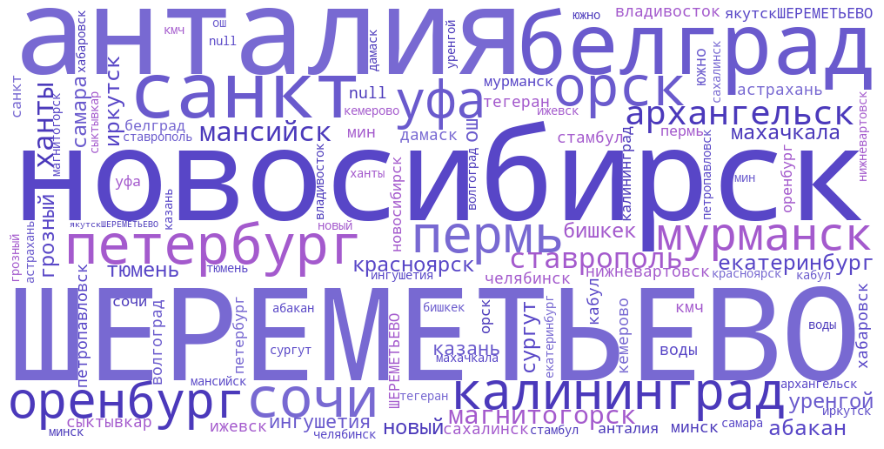

In [23]:
# формирование облака слов
from wordcloud import WordCloud
from stop_words import get_stop_words
import matplotlib.colors as mcolors
from matplotlib import cm 

STOPWORDS_RU = get_stop_words('russian')

wordcloud = WordCloud(width = 1000, 
                      height = 500, 
                      random_state=42,
                      max_words = 100,
                      prefer_horizontal = 0.7,
                      contour_width = 1.5,
                      background_color='white', 
                      normalize_plurals = True,
                      colormap = rvb,
                      collocations=False, repeat = True, min_font_size = 10, 
                      stopwords = STOPWORDS_RU).generate(text)

# визуализация сформированного облака слов
plot_cloud(wordcloud)

# Базовый анализ выручки за май

In [24]:
rev.head(10)

,TimeThirty,DAT,Торговая точка,Касса,orgtype,terminal,tzone,TotalSumm
0,2022-05-01 00:00:00.000,2022-05-01,Торговая точка 0601,7683,Общепит,B,Чистая зона ВВЛ-вылет,755448.0
1,2022-05-04 13:30:00.000,2022-05-04,Торговая точка 2373,3114,Общепит,B,Общедоступная зона-вылет,46800.0
2,2022-05-05 18:00:00.000,2022-05-05,Торговая точка 8998,9887,Торговля,B,Чистая зона ВВЛ-вылет,160160.0
3,2022-05-25 22:00:00.000,2022-05-25,Торговая точка 8313,2251,Общепит,B,Чистая зона ВВЛ-вылет,248960.0
4,2022-05-10 00:30:00.000,2022-05-10,Торговая точка 8998,9887,Торговля,B,Чистая зона ВВЛ-вылет,117600.0
5,2022-05-25 14:30:00.000,2022-05-25,Торговая точка 2968,9033,Общепит,B,Чистая зона ВВЛ-вылет,5272800.0
6,2022-05-25 15:30:00.000,2022-05-25,Торговая точка 5648,6213,Общепит,B,Общедоступная зона-вылет,721120.0
7,2022-05-04 17:30:00.000,2022-05-04,Торговая точка 0601,7683,Общепит,B,Чистая зона ВВЛ-вылет,735549.6
8,2022-05-05 20:00:00.000,2022-05-05,Торговая точка 8998,9887,Торговля,B,Чистая зона ВВЛ-вылет,250640.0
9,2022-05-05 21:30:00.000,2022-05-05,Торговая точка 5648,3601,Общепит,B,Чистая зона ВВЛ-прилет,100720.0


In [25]:
rev.TotalSumm.sum()

8381013922.4

In [26]:
day_rev = pd.pivot_table(rev,
               index=["DAT","Торговая точка"],
               values=["TotalSumm"],
               aggfunc="sum"
               ).reset_index()
day_rev.rename(columns = {'TotalSumm' : "Прибыль_день"}, inplace = True) 
day_rev

,DAT,Торговая точка,Прибыль_день
0,2022-05-01,Торговая точка 0601,42057156.0
1,2022-05-01,Торговая точка 2373,8518400.0
2,2022-05-01,Торговая точка 2968,130298240.0
3,2022-05-01,Торговая точка 3726,45669520.0
4,2022-05-01,Торговая точка 5648,19842640.0
...,...,...,...
233,2022-05-31,Торговая точка 2968,103404640.0
234,2022-05-31,Торговая точка 3726,39453680.0
235,2022-05-31,Торговая точка 5648,16836000.0
236,2022-05-31,Торговая точка 8313,31554800.0


Найдем лидеров по выручке за месяц

In [27]:
day_rev.groupby('Торговая точка')['Прибыль_день'].sum().round(1).sort_values(ascending = False).astype(int)

Торговая точка
Торговая точка 2968    3408585641
Торговая точка 0601    1635165200
Торговая точка 3726    1248330640
Торговая точка 8313     852381360
Торговая точка 8998     449308080
Торговая точка 5648     419581920
Торговая точка 2373     192717080
Торговая точка 8219     174944000
Name: Прибыль_день, dtype: int64

In [28]:
rev['час_покупки'] = rev['TimeThirty'].astype('datetime64[s]').dt.round('H')

r = rev.groupby('час_покупки')['TotalSumm'].sum().reset_index()
fig = px.bar(r, x='час_покупки',y='TotalSumm', text='TotalSumm')
fig.update_layout(
    title_text='Почасовая выручка за май', 
    xaxis_title_text='Дата', 
    yaxis_title_text='Сумма выручки',
    bargap=0.2, 
    bargroupgap=0.1,  font_size=15,
   # width = 1400  
)
fig.update_traces(marker_color='#cd5a84',textfont_size=14)
#fig.add_shape( # add a horizontal "target" line
 #   type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
 #   x0=0, x1=1, xref="paper", y0=100000, y1=100000, yref="y"
#)
fig.show()

Для удобства разбили покупки по часа. Логично, что выручка падает по ночам не в целом не однородна в течение дня.

In [29]:
rev['час'] = rev['час_покупки'].dt.hour
mean_r = rev.groupby(['час','orgtype'])['TotalSumm'].mean().round(0).reset_index()
mean_r2 = rev.groupby(['час'])['TotalSumm'].mean().round(0).reset_index()
mean_hour = mean_r2['TotalSumm'].mean()

fig = px.bar(mean_r, x='час',y='TotalSumm', color="orgtype",
             labels={ "TotalSumm": "Средняя выручка в час", "orgtype": "Тип точки" },
             color_discrete_map={"Общепит": "#cd5a84", "Торговля": "#a45acd"}
             #category_orders={ "час": ["00","01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20","21","22","23"]}
             )
fig.update_layout(
    title_text='Средняя почасовая выручка в мае', 
    xaxis_title_text='Час', 
    yaxis_title_text='Средняя выручка',
   # bargap=0.2, 
    #bargroupgap=0.1,  
    font_size=15,   
)
fig.add_shape( # add a horizontal "target" line
    type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
    x0=0, x1=1, xref="paper", y0=mean_hour, y1=mean_hour, yref="y"
)
#fig.update_traces(marker_color=('#6A5ACD','#a45acd'),textfont_size=14)
fig.show()

Видим разительное преимущество по выручке в точках общепита. В целом выручка точек возрастает в утренние, обеденные и вечерние часы. Если отфильтровать только выручку по точкам торговли, то колебания тоже присутствуют, но более равномерны. 

Посчитаем точные доли в мае.

In [30]:
part_rev = rev.groupby(['orgtype'])['TotalSumm'].sum().astype(int).reset_index()
fig = px.pie(part_rev, values='TotalSumm', names='orgtype',
             labels={ "TotalSumm": "Доля выручки в мае", "orgtype": "Тип точки" },
             color_discrete_sequence = ("#cd5a84", "#a45acd")
             )
fig.update_layout(
    title_text='Доли выручки в мае по точкам', 
    width = 800, 
    font_size=15,   
)
fig.show()

Проанализируем также динамику выручки по дням

In [31]:
rev['час'] = rev['час_покупки'].dt.hour
sum_day = rev.groupby(['DAT'])['TotalSumm'].sum().reset_index()
fig = px.line(sum_day, x="DAT", y="TotalSumm", markers=True,#, color="continent"#, line_group="country", hover_name="country",         line_shape="spline", render_mode="svg"
                         labels={ "DAT": "Дата", "TotalSumm":"Сумма выручки"} 
              )
fig.update_traces(textposition="bottom right",
                  marker_color='#6A5ACD',line_color='#6A5ACD')

fig.update_layout(
    title_text='Динамика выручки по дням',     
    bargap=0.2, 
    bargroupgap=0.1,  font_size=13,
    width = 1500, height = 400  
)

fig.show()

Видим слабый восходящий тренд после 11 мая и пиковые значения 6, 20, 27 мая - это пятницы. Отметим это для будущего анализа.

# Анализ взаимосвязи выручки и пассажиропотока

In [32]:
pas.head(3)

,Дата рейса,Рейс,Вход в чистую зону,Выход на рейс,Терминал,Авиакомпания,Направление куда летит
0,2022-05-01,5N 237,2022-04-30 21:46:20,2022-05-01 00:21:00,B,5N,OVB
1,2022-05-01,5N 237,2022-04-30 21:46:47,2022-05-01 00:21:00,B,5N,OVB
2,2022-05-01,5N 237,2022-04-30 21:47:47,2022-05-01 00:21:00,B,5N,OVB


Найдем время, которое пассажиры провели в чистой зоне

In [33]:
pas['Время в зоне'] = pas['Выход на рейс'] - pas['Вход в чистую зону']
pas['Время в зоне'].describe()

count                        53482
mean     0 days 02:30:28.291761714
std      0 days 02:23:21.618430526
min                0 days 00:09:07
25%                0 days 01:25:48
50%                0 days 01:59:46
75%         0 days 02:49:14.750000
max                1 days 07:29:40
Name: Время в зоне, dtype: object

В среднем пассажиры проводят в чистой зоне 2,5 часа. Минимум в мае был 9 минут, а максимум 1 день и 7,5 часов. Посмотрим на частоту распределения.

In [34]:
pas['Минут в зоне'] = pas['Время в зоне'].dt.total_seconds()/60
fig = px.histogram(pas, x="Минут в зоне")
fig.update_layout(
    title_text='Распределене времени ожидания в чистой зоне', 
    xaxis_title_text='Минут в чистой зоне', 
    yaxis_title_text='Количество пассажиров',
    font_size=14,   
)
fig.update_traces(marker_color='#6A5ACD',textfont_size=14)
fig.show()

Из распределения видно, что чаще всего пассажиры проводят в чистой зоне 100 минут. Но, конечно, видим и всплеск ожидающих свой рейс почти сутки. Возможно это выбросы из-за отложенного рейса, а возможно кто-то изначально так планировал при перелете с пересадкой.

**Гипотеза 1. Чем больше пассажиров в чистой зоне в момент времени, тем больше выручка в момент времени.**

Посчитаем количество пассажиров в чистой зоне по часам и попробуем найти закономерности и взаимосвязи с суммой выручки. 

In [35]:
pd.options.mode.chained_assignment = None
pas['Дата входа'] = pas['Вход в чистую зону'].astype('datetime64[ns]').dt.round('D')
pas0503 = pas[pas['Дата входа'] <= pd.to_datetime('2022-05-03')]
pas0503['час_входа'] = pas0503['Вход в чистую зону'].astype('datetime64[s]').dt.round('H')
pas0503['час_выхода'] = pas0503['Выход на рейс'].astype('datetime64[s]').dt.round('H')
pas0503['час'] = pas0503['час_входа'].dt.hour

#считаем число пассажиров в момент времени
count_in = pas0503.groupby('час_входа')['час_входа'].count()
count_out = pas0503.groupby('час_выхода')['час_выхода'].count()
count_data = pd.concat([count_in, count_out], axis=1).fillna(0).cumsum()
per_hour = count_data['час_входа'] - count_data['час_выхода']
per_hour = pd.DataFrame(data = per_hour, columns = ['Пассажиров в чистой зоне']).reset_index()
#per_hour

#считаем выручку по часам
rev0503 = rev[rev['DAT'] <=  '2022-05-03']
rev0503 = rev0503.groupby('час_покупки')['TotalSumm'].sum()
rev_per_hour = pd.DataFrame(data = rev0503).reset_index()
#print(rev_per_hour)

per_hour1 = per_hour.merge(rev_per_hour, left_on='index', right_on='час_покупки') 

#строим графики
fig = px.line(per_hour1, x="index", y="Пассажиров в чистой зоне", markers=True,#, color="continent"#, line_group="country", hover_name="country",         line_shape="spline", render_mode="svg"
                         labels={ "index": "Дата и время" } 
                )
fig2 = px.line(per_hour1, x="index", y="TotalSumm",  markers=True,#, color="continent"#, text="TotalSumm", line_group="country", hover_name="country",         line_shape="spline", render_mode="svg"
                          labels={ "index": "Дата и время", "TotalSumm": "Выручка всего" }
                         
            )
fig.update_traces(textposition="bottom right",
                  marker_color='#6A5ACD',line_color='#6A5ACD')
fig2.update_traces(textposition="top right",
                  marker_color='#cd5a84',line_color='#cd5a84')

fig.update_layout(
    title_text='Количество пассажиров в чистой зоне во времени', 
    xaxis_title_text='Дата и время нахождения в чистой зоне', 
    yaxis_title_text='Количество пассажиров',
    bargap=0.2, 
    bargroupgap=0.1,  font_size=13,
    width = 1500, height = 400  
)
fig2.update_layout(
    title_text='Сумма выручки во времени', 
    xaxis_title_text='Дата и время получения выручки', 
    yaxis_title_text='Сумма',
    bargap=0.2, 
    bargroupgap=0.1,  font_size=13,
    width = 1500, height = 400  
)
fig.show()
fig2.show()


Видим пиковые количества по пассажиропотоку ближе к полночи каждый день. В течение дня же количество пассажиров неправдоподобно низкое. 

У выручки пики наблюдаются в обеденное время. Утром и верером также есть всплески.

Приходим к выводу, что в нашем случае прямой корреляции нет или, хотя подозреваем неполноту данных по пассажирам (ну не может в чистую зону Шереметьево за час днем выйти менее 10 пассажиров). На других периодах картина похожая. Для достоверного отвержения гипотезы посчитаем коэффициент корреляции.

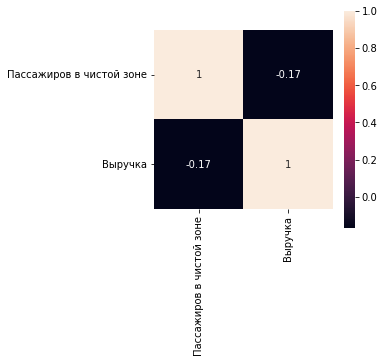

In [36]:
per_hour1.rename(columns = {'TotalSumm' : 'Выручка'}, inplace = True)    
plt.rcParams['figure.figsize']=(4,4)
g = sns.heatmap(per_hour1.corr(), square = True, annot=True)

Корреляция -0,17, то есть практически отсутствует. Гипотезу отвергаем.

In [37]:
#top15_pass = mean_flights.sort_values(by=['Ср_кол_пассажиров'], ascending=False).head(15)
mean_flights.sort_values(by=['Ср_кол_пассажиров'], ascending=False)

,Рейс,Авиакомпания,Направление куда летит,Терминал,Количество рейсов,Ср_кол_пассажиров
2,EO 1801,EO,AYT,C,13,289.769231
100,SU 2148,SU,AYT,C,3,199.666667
17,N4 563,N4,OSW,B,8,174.250000
0,5N 237,5N,OVB,B,29,170.482759
18,N4 567,N4,OSW,B,3,169.000000
...,...,...,...,...,...,...
72,SU 1500,SU,TJM,B,1,1.000000
73,SU 1506,SU,TJM,B,1,1.000000
28,SU 1002,SU,KGD,B,1,1.000000
25,SU 016,SU,LED,B,1,1.000000


Логично предположить, что пассажиры, летящие в столь трудный месяц зарубеж, могут позволить себе чуть больше и больше склонны к тратам. То есть выручка в терминале С в процентном соотношении может быть выше, но данных по торговым точкам в терминале С у нас нет.

In [38]:
rev['номер_точки'] = rev['Торговая точка'].str[-4:].astype(int)
rev.terminal.value_counts()

B    11840
Name: terminal, dtype: int64

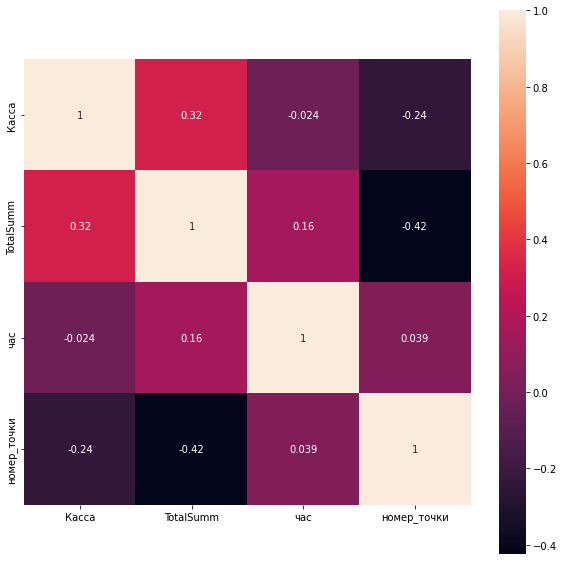

In [39]:
plt.rcParams['figure.figsize']=(10,10)
v = sns.heatmap(rev.corr(), square = True, annot=True)

В то же время есть слабая, но уже ближе к средней корреляция по сумме выручки и самой точкой. То есть важную роль играет расположение и тип точки.

Для составления прозноза проанализируем пассажиропоток за июнь.

In [56]:
pas06 = pd.read_excel("06.2022_Пассажиропоток.xlsx")
rev06 = pd.read_excel("06.2022_Выручка1.xlsx")
pas06

,Дата рейса,Рейс,Вход в чистую зону,Выход на рейс,Терминал,Авиакомпания,Направление куда летит
0,2022-06-01,5N 237,2022-05-31 21:36:12,2022-06-01 00:24:00,B,5N,OVB
1,2022-06-01,5N 237,2022-05-31 21:36:24,2022-06-01 00:24:00,B,5N,OVB
2,2022-06-01,5N 237,2022-05-31 21:37:35,2022-06-01 00:24:00,B,5N,OVB
3,2022-06-01,5N 237,2022-05-31 21:38:31,2022-06-01 00:24:00,B,5N,OVB
4,2022-06-01,5N 237,2022-05-31 21:39:05,2022-06-01 00:24:00,B,5N,OVB
...,...,...,...,...,...,...,...
91664,2022-06-30,WZ 5081,2022-06-29 23:18:23,2022-06-30 00:06:00,C,WZ,AYT
91665,2022-06-30,WZ 5081,2022-06-29 23:30:43,2022-06-30 00:06:00,C,WZ,AYT
91666,2022-06-30,WZ 5081,2022-06-29 23:30:52,2022-06-30 00:06:00,C,WZ,AYT
91667,2022-06-30,WZ 5081,2022-06-29 23:51:42,2022-06-30 00:06:00,C,WZ,AYT


In [57]:
flights06 = pd.pivot_table(pas06,
               index=["Дата рейса","Рейс","Авиакомпания","Направление куда летит","Терминал"],
               values=["Вход в чистую зону"],
               aggfunc="count").reset_index()
flights06.rename(columns = {'Вход в чистую зону' : 'Кол_пассажиров'}, inplace = True)  
mean_flights06 = pd.pivot_table(flights,
               index=["Рейс","Авиакомпания","Направление куда летит","Терминал"],
               values=["Кол_пассажиров","Дата рейса"],
               aggfunc={"Кол_пассажиров":"mean","Дата рейса":"count"}
               ).reset_index()
mean_flights06.rename(columns = {'Дата рейса' : "Количество рейсов", 'Кол_пассажиров' : "Ср_кол_пассажиров"}, inplace = True) 
mean_flights06.sort_values(by=['Ср_кол_пассажиров'], ascending=False)

,Рейс,Авиакомпания,Направление куда летит,Терминал,Количество рейсов,Ср_кол_пассажиров
133,WZ 5079,WZ,AYT,C,8,404.750000
134,WZ 5081,WZ,AYT,C,18,389.166667
117,SU 1742,SU,UUS,B,1,385.000000
136,WZ 5095,WZ,AYT,C,12,333.666667
9,EO 1801,EO,AYT,C,13,322.692308
...,...,...,...,...,...,...
96,SU 1528,SU,AER,B,1,1.000000
99,SU 1544,SU,PEZ,B,1,1.000000
109,SU 1672,SU,AER,B,1,1.000000
111,SU 1684,SU,KUF,B,1,1.000000


На первый взгляд по среднему числу пассажиров на рейсах - пассажиропоток вырос, что логично для июня.

Взглянем на число пассажиров в чистой зоне во времени.

In [69]:
pd.options.mode.chained_assignment = None
pas06['Дата входа'] = pas06['Вход в чистую зону'].astype('datetime64[ns]').dt.round('D')
pas0603 = pas06[pas06['Дата входа'] >= pd.to_datetime('2022-06-26')]
pas0603['час_входа'] = pas0603['Вход в чистую зону'].astype('datetime64[s]').dt.round('H')
pas0603['час_выхода'] = pas0603['Выход на рейс'].astype('datetime64[s]').dt.round('H')
pas0603['час'] = pas0503['час_входа'].dt.hour

#считаем число пассажиров в момент времени
count_in06 = pas0603.groupby('час_входа')['час_входа'].count()
count_out06 = pas0603.groupby('час_выхода')['час_выхода'].count()
count_data06 = pd.concat([count_in06, count_out06], axis=1).fillna(0).cumsum()
per_hour06 = count_data06['час_входа'] - count_data06['час_выхода']
per_hour06 = pd.DataFrame(data = per_hour06, columns = ['Пассажиров в чистой зоне']).reset_index()
#per_hour06
#per_hour106 = per_hour06.merge(rev_per_hour06, left_on='index', right_on='час_покупки') 

#строим графики
fig = px.line(per_hour06, x="index", y="Пассажиров в чистой зоне", markers=True,#, color="continent"#, line_group="country", hover_name="country",         line_shape="spline", render_mode="svg"
                         labels={ "index": "Дата и время" } 
                )                       
            
fig.update_traces(textposition="bottom right",
                  marker_color='#6A5ACD',line_color='#6A5ACD')

fig.update_layout(
    title_text='Количество пассажиров в чистой зоне во времени', 
    xaxis_title_text='Дата и время нахождения в чистой зоне', 
    yaxis_title_text='Количество пассажиров',
    bargap=0.2, 
    bargroupgap=0.1,  font_size=13,
    width = 1500, height = 400  
)

fig.show()

Имеем ту же картину, что и в мае - пиковые значения ближе к полуночи и неправдоподобно низкое число ждущих рейса в течение дня. Хотя пики визуально стали выше.

Посчитаем % роста числа пассажиров к маю.

In [58]:
print(pas['Дата рейса'].count())
print(pas06['Дата рейса'].count())
print((pas06['Дата рейса'].count() * 100 / pas['Дата рейса'].count()).round(1)-100,"%")

53482
91669
71.4 %


Число пассажиров выросло на 71%. Выросло и среднее количество пассажиров на рейсах - начался сезон отпусков.

# Моделирование прогноза выручки

Для составления прогноза выручки на июнь 2022 года изначально предполагалось воспользоваться методами машинного обучения Линейная регрессия или регрессией случайного леса библиотеки sklearn, с целью выбора оптимальной модели.

Для это необходимо:
Разделить выборку на обучающий и тестовый датасеты

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5)

Обучим модель двумя способами: **LinearRegression и RandomForestRegressor**, проанализировать предварительный результат и выбрать лучшую модель по метрикам **roc_auc_score** и выполнить предсказание.


In [ ]:
# Инициализация моделей линейной регрессии
#     from sklearn import linear_model
#     linear_regression = linear_model.LinearRegression()
# линейная регрессия со встроенной L1 регуляризацией
#     lasso = linear_model.Lasso()
# линейная регрессия со встроенной L2 регуляризацией
#     ridge = linear_model.Ridge()
# обучение модели
#     linear_regression.fit(X_train, y_train)
# получение предсказаний
#     y_pred = linear_regression.predict(X_val)
# получение коэффициентов линейной регрессии
#     print(model.coef_)
# получение нулевого коэффициента регрессии
#     print(model.intercept_)

Основными параметрами предполагалось взять число нахождения пассажиров в момент времени в числой зоне, рейс (зарубежный/внутренний), время суток, время ожидания рейса (т.к. слишком рано приезжающие пассажиры наверняка захотят что-то купить). 

Но поскольку у нас имеются явные перекосы в данных пассажиропотока на ночные рейсы и не совпадения с пиков выручки(на примере мая), модели регрессии показали свою несостоятельность. Принято решение использовать простое процентное моделирование по числу пассажиров.

In [83]:
rev2 = rev.pivot_table(index = ['TimeThirty','DAT','Торговая точка'], values = 'TotalSumm', aggfunc='sum').reset_index()
rev2

,TimeThirty,DAT,Торговая точка,TotalSumm
0,2022-05-01 00:00:00.000,2022-05-01,Торговая точка 0601,755448.0
1,2022-05-01 00:00:00.000,2022-05-01,Торговая точка 2373,38800.0
2,2022-05-01 00:00:00.000,2022-05-01,Торговая точка 2968,712000.0
3,2022-05-01 00:00:00.000,2022-05-01,Торговая точка 3726,44000.0
4,2022-05-01 00:00:00.000,2022-05-01,Торговая точка 5648,387920.0
...,...,...,...,...
8947,2022-05-31 23:30:00.000,2022-05-31,Торговая точка 2968,1379200.0
8948,2022-05-31 23:30:00.000,2022-05-31,Торговая точка 3726,1090400.0
8949,2022-05-31 23:30:00.000,2022-05-31,Торговая точка 5648,231040.0
8950,2022-05-31 23:30:00.000,2022-05-31,Торговая точка 8313,514080.0


In [99]:
rev2['TimeThirty_прогноз'] = rev2['TimeThirty'].str.replace('05', '06')
rev2['DAT_прогноз'] = rev2['DAT'].str.replace('05', '06')
rev2['TotalSumm_прогноз'] = rev2['TotalSumm'] * 1.75
rev_pred = rev2[rev2['DAT'] != '2022-05-31']
rev_pred = rev_pred.drop(columns = ['TimeThirty','DAT'],axis = 1)
rev_pred = rev_pred.reindex(columns=['DAT_прогноз','TimeThirty_прогноз','TotalSumm_прогноз','Торговая точка'])
rev_pred.columns = ['DAT','TimeThirty','TotalSumm_прогноз','Торговая точка']
rev_pred

,DAT,TimeThirty,TotalSumm_прогноз,Торговая точка
0,2022-06-01,2022-06-01 00:00:00.000,1322034.0,Торговая точка 0601
1,2022-06-01,2022-06-01 00:00:00.000,67900.0,Торговая точка 2373
2,2022-06-01,2022-06-01 00:00:00.000,1246000.0,Торговая точка 2968
3,2022-06-01,2022-06-01 00:00:00.000,77000.0,Торговая точка 3726
4,2022-06-01,2022-06-01 00:00:00.000,678860.0,Торговая точка 5648
...,...,...,...,...
8653,2022-06-30,2022-06-30 23:30:00.000,1219400.0,Торговая точка 2968
8654,2022-06-30,2022-06-30 23:30:00.000,154000.0,Торговая точка 3726
8655,2022-06-30,2022-06-30 23:30:00.000,1158780.0,Торговая точка 5648
8656,2022-06-30,2022-06-30 23:30:00.000,712600.0,Торговая точка 8313


In [86]:
#rev06 = rev06.pivot_table(index = ['TimeThirty','DAT','Торговая точка'], values = 'TotalSumm', aggfunc='sum').reset_index()
#rev06['TotalSumm'] = rev06['TotalSumm'].astype(str).str.replace(",",".").str.replace("\xa0","").astype(float)
#rev06

In [102]:
rev_pred.to_excel('062022_Выручка_прогноз.xlsx', index = False)
from google.colab import files
files.download("062022_Выручка_прогноз.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>